In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams
from utils.utils import *
from dtw import dtw


np.random.seed(2)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# Set device
print(f'The device used in this notebook is: {setDevice()}')

DEVICE = setDevice()

The device used in this notebook is: cuda


#### Import data

In [3]:
# Set settings
features, input_window, output_window, stride = set_settings()

print(f'features: {features}')
print(f'input_window: {input_window}')
print(f'output_window: {output_window}')
print(f'stride: {stride}')

features: ['Hips Flexion-Extension Left', 'Knees Flexion-Extension Left', 'Ankles Dorsiflexion-Plantarflexion Left', 'Hips Flexion-Extension Right', 'Knees Flexion-Extension Right', 'Ankles Dorsiflexion-Plantarflexion Right']
input_window: 100
output_window: 1
stride: 1


In [4]:
file_dir = r'D:\Study 2 Data\Healthy Gait\Train_Val' 
# file_dir = r'D:\Study 2 Data\CP Gait\Train'
train_files = os.listdir(file_dir) 

# Changes the working directory to get the data from their location 
os.chdir(file_dir)
cwd = os.getcwd()

print(f'Current working directory is: {cwd}')
print(f"There are {len(train_files)} files in the specified path.")

Current working directory is: D:\Study 2 Data\Healthy Gait\Train_Val
There are 10 files in the specified path.


In [5]:
train_files

['AB2188 BF T1-5.csv',
 'AB3154 BF T6-10.csv',
 'AB6751 BF T1-5.csv',
 'AB7422 BF T1-5.csv',
 'AB7779 BF T1-5.csv',
 'AB9119 BF T1-5.csv',
 'AB9737 BF T1-5.csv',
 'AB9737 BF T6-10.csv',
 'AB9738 BF T1-5.csv',
 'RP1677 V1 BF T1-5.csv']

In [6]:
#Create feature list to extract values needed from CSV files
all_features = ['Trial', 'Time'] + features
all_features


['Trial',
 'Time',
 'Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [7]:
all_data = create_dataframe(train_files, all_features)

Extracting data from: AB2188 BF T1-5.csv
Extracting data from: AB3154 BF T6-10.csv
Extracting data from: AB6751 BF T1-5.csv
Extracting data from: AB7422 BF T1-5.csv
Extracting data from: AB7779 BF T1-5.csv
Extracting data from: AB9119 BF T1-5.csv
Extracting data from: AB9737 BF T1-5.csv
Extracting data from: AB9737 BF T6-10.csv
Extracting data from: AB9738 BF T1-5.csv
Extracting data from: RP1677 V1 BF T1-5.csv


In [8]:
all_data.reset_index(drop=True, inplace=True) #reset the index of the table
# path = r'D:\Study 2 Data\Healthy Gait' + '\\' + 'all_data_healthy_train.csv'
# all_data.to_csv(path)

In [9]:
all_data

,Patient ID,Trial,Time,Hips Flexion-Extension Left,Knees Flexion-Extension Left,Ankles Dorsiflexion-Plantarflexion Left,Hips Flexion-Extension Right,Knees Flexion-Extension Right,Ankles Dorsiflexion-Plantarflexion Right
0,AB2188 BF T1-5,1,223.83,24.69730,43.98116,13.16722,7.40105,19.83552,3.46198
1,AB2188 BF T1-5,1,223.84,24.44713,43.17039,13.07729,7.04358,19.57988,3.53245
2,AB2188 BF T1-5,1,223.85,24.17547,42.45852,13.01625,6.69202,19.29897,3.58736
3,AB2188 BF T1-5,1,223.86,23.88122,41.82635,12.98980,6.35465,19.00309,3.63057
4,AB2188 BF T1-5,1,223.87,23.56337,41.25273,13.00300,6.03926,18.70273,3.66602
...,...,...,...,...,...,...,...,...,...
97365,RP1677 V1 BF T1-5,8,599.64,-6.93656,10.82815,-35.73075,9.91959,27.10278,-40.89069
97366,RP1677 V1 BF T1-5,8,599.65,-5.40192,11.88957,-37.14417,9.41865,26.10446,-41.32368
97367,RP1677 V1 BF T1-5,8,599.66,-3.99662,12.89493,-38.42186,8.87176,25.07484,-41.66603
97368,RP1677 V1 BF T1-5,8,599.67,-2.76106,13.83548,-39.51443,8.28708,24.04106,-41.89437


In [10]:
n_trials = all_data['Trial'].max()
print(f'maximum number of trials is: {n_trials}')

maximum number of trials is: 16


In [11]:
all_data['Patient ID'].unique()

array(['AB2188 BF T1-5', 'AB3154 BF T6-10', 'AB6751 BF T1-5',
       'AB7422 BF T1-5', 'AB7779 BF T1-5', 'AB9119 BF T1-5',
       'AB9737 BF T1-5', 'AB9737 BF T6-10', 'AB9738 BF T1-5',
       'RP1677 V1 BF T1-5'], dtype=object)

In [12]:
# # Healthy Subjects 
# train_subjects = ['AB2188 BF T1-5',
#                     'AB3154 BF T6-10', 
#                     'AB6751 BF T1-5',
#                     'AB7422 BF T1-5',
#                     'AB7779 BF T1-5', 
#                     'AB9737 BF T1-5', 
#                     'AB9737 BF T6-10', 
#                     'AB9738 BF T1-5']

# val_subjects = ['AB9119 BF T1-5']


In [13]:
# Healthy Subjects 
train_subjects = ['AB3154 BF T6-10', 
                    'AB6751 BF T1-5',
                    'AB7422 BF T1-5',
                    'AB7779 BF T1-5',
                    'AB9119 BF T1-5', 
                    'AB9737 BF T1-5', 
                    'AB9737 BF T6-10', 
                    'AB9738 BF T1-5']

val_subjects = ['AB2188 BF T1-5']


In [14]:
val_subjects

['AB2188 BF T1-5']

In [15]:
train_data = all_data.loc[all_data['Patient ID'].isin(train_subjects)]

val_data = all_data.loc[all_data['Patient ID'].isin(val_subjects)]

In [16]:
print(f'all_data: {all_data.shape}')
print(f'train_data: {train_data.shape}')
print(f'val_data: {val_data.shape}')

all_data: (97370, 9)
train_data: (77890, 9)
val_data: (7262, 9)


In [17]:
train_samples = count_nsamples(train_data)
val_samples = count_nsamples(val_data)

For patient: AB3154 BF T6-10, trial: 1, there are: 651 time-points
For patient: AB3154 BF T6-10, trial: 2, there are: 541 time-points
For patient: AB3154 BF T6-10, trial: 3, there are: 613 time-points
For patient: AB3154 BF T6-10, trial: 4, there are: 601 time-points
For patient: AB3154 BF T6-10, trial: 5, there are: 711 time-points
For patient: AB3154 BF T6-10, trial: 6, there are: 651 time-points
For patient: AB3154 BF T6-10, trial: 7, there are: 1031 time-points
For patient: AB3154 BF T6-10, trial: 8, there are: 896 time-points
For patient: AB3154 BF T6-10, trial: 9, there are: 812 time-points
For patient: AB6751 BF T1-5, trial: 1, there are: 761 time-points
For patient: AB6751 BF T1-5, trial: 2, there are: 733 time-points
For patient: AB6751 BF T1-5, trial: 3, there are: 731 time-points
For patient: AB6751 BF T1-5, trial: 4, there are: 682 time-points
For patient: AB6751 BF T1-5, trial: 5, there are: 710 time-points
For patient: AB6751 BF T1-5, trial: 6, there are: 708 time-points


In [18]:
print(f'Number of train samples: {train_samples}')
print(f'Number of validation samples: {val_samples}')

Number of train samples: 88
Number of validation samples: 10


In [19]:
m = all_data['Patient ID'].unique()

In [20]:

def pd_to_np_converter(data, n_samples, features):
    #create a numpy array that stores the data for export
    sample_ID = []
    # patients = 2
    # n_trials = 10
    # # samples = patients * n_trials
    data_store = np.zeros((n_samples, 2000, len(features)), dtype=np.float32)
    i = 0

    for p in data['Patient ID'].unique(): #loop over patients 
        for t in data['Trial'].unique(): #loop over trials starting with trials 1 to trial 9 (inclusive)
            pd_array = data[(data['Patient ID'] == p) & (data['Trial'] == t)]
            if pd_array.empty:
                continue
                # print('DataFrame is empty!')
                # print(f'Trail {t} does not exist in {p}')
            else:
                np_array = pd_array.to_numpy()
                data_store[i, :np_array.shape[0], :] = np_array[:,3:] 
                sample_ID.append(p+ ' Ts'+str(t)) 
                i +=1

    return pd_array.columns, data_store


In [21]:
train_columns, train_data_np = pd_to_np_converter(train_data, train_samples, features)
val_columns, val_data_np = pd_to_np_converter(val_data, val_samples, features)

print(f'train_data_np.shape: {train_data_np.shape}')
print(f'val_data_np.shape: {val_data_np.shape}')

train_data_np.shape: (88, 2000, 6)
val_data_np.shape: (10, 2000, 6)


In [22]:
train_columns[3:].tolist() 

['Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [23]:
features == train_columns[3:].tolist() 

True

In [24]:
labels_keys = train_columns[3:].tolist() #copy the train columns removing the first column headers'Patient ID', 'Trial', 'Time'


if features == labels_keys: # check that the features are the same as the label keys 
    print('YAY! Column headers of dataframe match features')
else:
    print('ERROR: Features and labels_keys do not match!')

YAY! Column headers of dataframe match features


In [25]:
labels_keys = features 

labels_idx = np.arange(0, len(labels_keys), 1)

labels = dict(zip(labels_keys, labels_idx))

len(labels)
labels
# labels_keys

{'Hips Flexion-Extension Left': 0,
 'Knees Flexion-Extension Left': 1,
 'Ankles Dorsiflexion-Plantarflexion Left': 2,
 'Hips Flexion-Extension Right': 3,
 'Knees Flexion-Extension Right': 4,
 'Ankles Dorsiflexion-Plantarflexion Right': 5}

In [26]:
def window_generator_fltrd(sequence, input_window, output_window, stride, features, labels):
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    # shortest_seqLen = float('inf')

    # f_zeros = [] #array that stores the number of leading zeros for each feature
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        # f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(max_b_zeros)

    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)
    trimmed_seqLen_reduced = trimmed_seqLen - 300 #reducing sequence size to remove the first and last 200 timesteps which may contain errors   
    print(f'trimmed_seqLen: {trimmed_seqLen}')
    print(f'trimmed_seqLen_reduced: {trimmed_seqLen_reduced}')


    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen_reduced - (input_window+output_window)) // stride) + 1
    print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + 150

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, labels[feature]]

    return X_values, Y_values 

In [27]:
def window_generator_lt_fltrd(sequence, input_window, future_window, stride, features, labels): #window gernerator long term fltrd (creats a validation window up to 200 timesteps in advance to measure error on long term future predictions)
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(max_b_zeros)

    fltrd_samples = 2 * 150 #remove 100 timesteps from the beggining and ending of the entire sequence
    # lt_len = 200 # number of timesteps to predict in the future based on a single input window (to be used in measuring errors based on prediction input)
    
    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)
    trimmed_seqLen_reduced = trimmed_seqLen - (fltrd_samples) # (- fltrd_samples is done to reduce sequence size to remove the first and last 150 timesteps which may contain errors since they corresponding to beggining and ending of the trials 
    print(f'trimmed_seqLen: {trimmed_seqLen}')
    print(f'trimmed_seqLen_reduced: {trimmed_seqLen_reduced}')


    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen_reduced - (input_window+future_window)) // stride) + 1
    print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + 150

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")
        # return None 

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), future_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + future_window, labels[feature]]

    return X_values, Y_values 

In [28]:
# Creating training datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 900


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_train_windows = np.zeros((samples_per_file*train_samples, input_window, len(features)), dtype=np.float64) #size can be reduced by decreasing train_size 
Y_train_windows = np.zeros((samples_per_file*train_samples, output_window, len(features)), dtype=np.float64) 


start_idx = 0 #setting start index to equal zero 
train_sample_sum = 0
train_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(train_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        train_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_train_windows[start_idx:end_idx, :, :] = X_values
    Y_train_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    train_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_train_data = X_train_windows[:end_idx, :, :].astype('float64')
Y_train_data = Y_train_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_train_windows: {X_train_windows.shape}')
print(f'shape of Y_train_windows: {Y_train_windows.shape}')

print(f'shape of X_train_data: {X_train_data.shape}')
print(f'shape of Y_train_data: {Y_train_data.shape}')

trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 541
trimmed_seqLen_reduced: 241
number of slides is: 141
trimmed_seqLen: 613
trimmed_seqLen_reduced: 313
number of slides is: 213
trimmed_seqLen: 601
trimmed_seqLen_reduced: 301
number of slides is: 201
trimmed_seqLen: 711
trimmed_seqLen_reduced: 411
number of slides is: 311
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 1031
trimmed_seqLen_reduced: 731
number of slides is: 631
trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 496
trimmed_seqLen: 812
trimmed_seqLen_reduced: 512
number of slides is: 412
trimmed_seqLen: 761
trimmed_seqLen_reduced: 461
number of slides is: 361
trimmed_seqLen: 733
trimmed_seqLen_reduced: 433
number of slides is: 333
trimmed_seqLen: 731
trimmed_seqLen_reduced: 431
number of slides is: 331
trimmed_seqLen: 682
trimmed_seqLen_reduced: 382
number of slides is: 282
trimmed_seqLen: 710
trimmed_seqLen_reduced: 410
nu

In [29]:
# Creating validation datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float64) #size can be reduced by decreasing train_size 
Y_val_windows = np.zeros((samples_per_file*val_samples, output_window, len(features)), dtype=np.float64) 


start_idx = 0 #setting start index to equal zero 
val_sample_sum = 0
val_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_windows[start_idx:end_idx, :, :] = X_values
    Y_val_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_data = X_val_windows[:end_idx, :, :].astype('float64')
Y_val_data = Y_val_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_windows: {X_val_windows.shape}')
print(f'shape of Y_val_windows: {Y_val_windows.shape}')

print(f'shape of X_val_data: {X_val_data.shape}')
print(f'shape of Y_val_data: {Y_val_data.shape}')

trimmed_seqLen: 718
trimmed_seqLen_reduced: 418
number of slides is: 318
trimmed_seqLen: 801
trimmed_seqLen_reduced: 501
number of slides is: 401
trimmed_seqLen: 706
trimmed_seqLen_reduced: 406
number of slides is: 306
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 741
trimmed_seqLen_reduced: 441
number of slides is: 341
trimmed_seqLen: 691
trimmed_seqLen_reduced: 391
number of slides is: 291
trimmed_seqLen: 722
trimmed_seqLen_reduced: 422
number of slides is: 322
trimmed_seqLen: 726
trimmed_seqLen_reduced: 426
number of slides is: 326
trimmed_seqLen: 740
trimmed_seqLen_reduced: 440
number of slides is: 340
trimmed_seqLen: 766
trimmed_seqLen_reduced: 466
number of slides is: 366
shape of X_val_windows: (16000, 100, 6)
shape of Y_val_windows: (16000, 1, 6)
shape of X_val_data: (3262, 100, 6)
shape of Y_val_data: (3262, 1, 6)


In [30]:
# Creating validation datasets (long term predictions)
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600

future_window = 200

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_lt_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float64) #size can be reduced by decreasing train_size 
Y_val_lt_windows = np.zeros((samples_per_file*val_samples, future_window, len(features)), dtype=np.float64) 


start_idx = 0 #setting start index to equal zero 
val_lt_sample_sum = 0
val_lt_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
       
    X_values, Y_values = window_generator_lt_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        future_window=future_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_lt_windows[start_idx:end_idx, :, :] = X_values
    Y_val_lt_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_lt_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_lt_data = X_val_lt_windows[:end_idx, :, :].astype('float64')
Y_val_lt_data = Y_val_lt_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_lt_windows: {X_val_lt_windows.shape}')
print(f'shape of Y_val_lt_windows: {Y_val_lt_windows.shape}')

print(f'shape of X_val_lt_data: {X_val_lt_data.shape}')
print(f'shape of Y_val_lt_data: {Y_val_lt_data.shape}')

trimmed_seqLen: 718
trimmed_seqLen_reduced: 418
number of slides is: 119
trimmed_seqLen: 801
trimmed_seqLen_reduced: 501
number of slides is: 202
trimmed_seqLen: 706
trimmed_seqLen_reduced: 406
number of slides is: 107
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 52
trimmed_seqLen: 741
trimmed_seqLen_reduced: 441
number of slides is: 142
trimmed_seqLen: 691
trimmed_seqLen_reduced: 391
number of slides is: 92
trimmed_seqLen: 722
trimmed_seqLen_reduced: 422
number of slides is: 123
trimmed_seqLen: 726
trimmed_seqLen_reduced: 426
number of slides is: 127
trimmed_seqLen: 740
trimmed_seqLen_reduced: 440
number of slides is: 141
trimmed_seqLen: 766
trimmed_seqLen_reduced: 466
number of slides is: 167
shape of X_val_lt_windows: (16000, 100, 6)
shape of Y_val_lt_windows: (16000, 200, 6)
shape of X_val_lt_data: (1272, 100, 6)
shape of Y_val_lt_data: (1272, 200, 6)


In [31]:
X_train_norm, scalars = normalise_fit(X_train_data)
Y_train_norm = normalise_transform(Y_train_data, scalars)

X_val_norm = normalise_transform(X_val_data, scalars)
Y_val_norm = normalise_transform(Y_val_data, scalars)

X_val_lt_norm = normalise_transform(X_val_lt_data, scalars)
Y_val_lt_norm = normalise_transform(Y_val_lt_data, scalars)


scalars

array([[-30.96504974,  -9.91796017, -49.7908783 , -34.52795029,
        -14.86672974, -47.07204819],
       [ 90.99295044, 111.41835022,  27.9573307 ,  61.78282166,
         91.98961639,  37.62150955]])

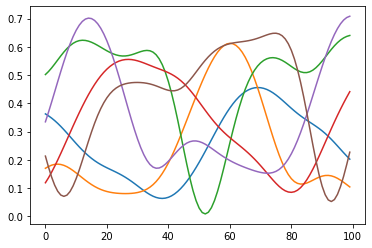

In [32]:
plt.plot(X_train_norm[2089,:])

In [33]:
# Convert to Tensor 
# do not store on GPU (yet)
X_train = torch.from_numpy(X_train_norm).to(torch.float64)
Y_train = torch.from_numpy(Y_train_norm).to(torch.float64)

# X_val = torch.from_numpy(X_val_norm).float()

# X_val_resized = np.expand_dims(Y_val_norm[:,0,:], axis=1)
# Y_val = torch.from_numpy(X_val_resized).float()

X_val = torch.from_numpy(X_val_norm).to(torch.float64)
Y_val = torch.from_numpy(Y_val_norm).to(torch.float64)


X_val_lt = torch.from_numpy(X_val_lt_norm).to(torch.float64)
Y_val_lt = torch.from_numpy(Y_val_lt_norm).to(torch.float64)


print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

print(f'X_val_lt shape: {X_val_lt.shape}') #long term predictions
print(f'Y_val_lt shape: {Y_val_lt.shape}') #long term predictions




X_train shape: torch.Size([42690, 100, 6])
Y_train shape: torch.Size([42690, 1, 6])
X_val shape: torch.Size([3262, 100, 6])
Y_val shape: torch.Size([3262, 1, 6])
X_val_lt shape: torch.Size([1272, 100, 6])
Y_val_lt shape: torch.Size([1272, 200, 6])


In [34]:
X_val.dtype

torch.float64

In [35]:
# len(train_dataloader)

### Model training


#### Another tutorial:
https://www.kaggle.com/code/seangribben/lstm-time-series-prediction-pytorch-sine-wave

In [36]:
print(f'shape of X_train: {X_train.shape}, shape of Y_train: {Y_train.shape}')

shape of X_train: torch.Size([42690, 100, 6]), shape of Y_train: torch.Size([42690, 1, 6])


In [37]:
# train_dataset = gaitDataset(X_train, Y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle = False)
# # train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle = False)

# val_dataset = gaitDataset(X_val, Y_val) #ADJUSTED
# # val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [38]:
# train_dataset.shape
# train_labels.shape

In [39]:
# #Vanilla LSTM
# class Net(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(Net, self).__init__()
        
#         # self.fc1 = nn.Linear(input_shape, n_neurons)
#         self.lstm = nn.LSTM(input_size=input_shape, hidden_size=n_neurons)
#         self.fc = nn.Linear(n_neurons, 1)
    
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         # out = self.fc1(x)
#         out = self.fc(out)
#         return out

In [40]:
# # Vanilla LSTM
# class LSTM(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(LSTM, self).__init__()
        
#         self.lstm = nn.LSTM(input_size=len(features), hidden_size=n_neurons, num_layers=2, batch_first = True)
#         self.fc = nn.Linear(n_neurons, len(features))

#     def forward(self, x):
#         # print(f'input shape: {x.shape}')
#         out, _ = self.lstm(x)

#         out = self.fc(out[:,-1])

#         return out.unsqueeze(1)

In [41]:
# # useful resources: https://www.youtube.com/watch?v=8A6TEjG2DNw (LSTM Time Series Prediction Tutorial using PyTorch in Python | Coronavirus Daily Cases Forecasting)
# LSTM model 
class LSTM(nn.Module):
    def __init__(self, params):
        super(LSTM, self).__init__()
        '''
        nn.lstm: 
        input_size = number of features in input, if batch_first = TRUE (batchSize, seq_len, Hin) FEATURES
        hidden_size = number of features in hidden state
        num_layers
        batch_first = if TRUE (batch, seq, Hin) Hin may mean input features
        h_0 = (D * num_layers, batchSize, Hout)
        c_0 = (D * num_layers, batchSize, Hcell)

        output = (batchSize, seq_len, D * Hout) Hout may mean output features, if batch first = TRUE 
        h_0 = (D*num_layers, N, Hout) final state for each element in the batch 
        C_0 = (D*num_layers, N, Hcell) final cell state for each element 

        nn.linear:
        input_size = (N,*, Hin) Hin = input_features (equal to hidden size therefore is arbitrarily set)
        output_size = (N, *, Hout) Hout = output features (equal to output_size passed in to the model) 

        '''
        # Pytorch documentation: 
        # >>> rnn = nn.LSTM(10, 20, 2) features, hidden_size, number of layers 
        # >>> input = torch.randn(5, 3, 10) in_seq_len, batch_size, hidden_size (batch size should not be input to the mode, inferred from the shape of the input and will be the first number if batch_first = TRUE)
        # >>> h0 = torch.randn(2, 3, 20)
        # >>> c0 = torch.randn(2, 3, 20)
        # >>> output, (hn, cn) = rnn(input, (h0, c0))

        self.input_size = len(features)
        self.hidden_size = params['hidden_size']
        self.num_layers = params['num_layers']
        self.in_seq_len = 100
        self.output_size = len(features)
        self.out_seq_len = output_window
        self.device = DEVICE
        
        # nn.LSTM(features, hidden_size, number of layers)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)

        #nn.fc1
        self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))
        # self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):

        # initialise hidden and cell states after passing through each batch (this is skipped in stateless model)
        h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device) # input_data.shape[0] is equal to batch size
        c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device)

        #propagate through LSTM
        lstm_out, (h_out, c_out) = self.lstm(input_data, (h_0, c_0))
        # print(f'shape h_out[-1] {h_out.shape}')
        # propagate through linear layer 
        fc1_out = self.fc1(h_out[-1])
       
        preds = fc1_out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')
        
        return preds

In [42]:
# # MLP
# class Net(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(Net, self).__init__()
#         self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
#         self.fc1 = nn.Linear(input_shape, n_neurons)
#         self.fc = nn.Linear(n_neurons, 1)
#         # self.relu = nn.ReLU()
#     def forward(self, x):
#         # print(f'input: {x.shape}')
#         out = self.flatten(x)
#         # print(f'flatten output: {out.shape}')
#         out = self.fc1(out)
#         # out = self.relu(out)
#         # print(f'fc1 shape: {out.shape}')
#         out = self.fc(out)
#         # print(f'output.shape {out.shape}')
#         return out.unsqueeze(1)

In [43]:
# # MLP
# class MLP(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(MLP, self).__init__()

#         self.flatten = nn.Flatten(1,-1)
#         self.fc1 = nn.Linear(input_shape*len(features), n_neurons)
#         self.fc = nn.Linear(n_neurons, len(features))
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # print(f'input: {x.shape}')
#         out = self.flatten(x)
#         # print(f'flatten output: {out.shape}')
#         out = self.fc1(out)
#         out = self.relu(out)
#         # print(f'fc1 shape: {out.shape}')
#         out = self.fc(out)
#         # print(f'output.shape {out.shape}')
#         return out.unsqueeze(1)

In [44]:
# # MLP
# class MLP(nn.Module):
#     def __init__(self, n_neurons, input_shape):
#         super(MLP, self).__init__()
        
#         self.fc1 = nn.Linear(input_shape, n_neurons)
#         self.fc2 = nn.Linear(n_neurons, n_neurons)

#         self.fc3 = nn.Linear(n_neurons, n_neurons)
 
#         # self.fc1 = nn.Linear(n_neurons, n_neurons)

#         # self.lstm = nn.LSTM(input_size=input_shape, hidden_size=n_neurons)
#         self.fc = nn.Linear(n_neurons, 1)
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         # print(f'input shape: {x.permute(2,0,1).shape}')
#         # out, _ = self.lstm(x)
#         out = self.fc1(x.permute(2,0,1))
#         out = self.relu(out)

#         out = self.fc2(out)
#         out = self.relu(out)
        
#         out = self.fc3(out)
#         out = self.relu(out)

#         # print(f'lstm out shape: {out.shape}')
#         out = self.fc(out)
#         # print(f'output.shape {out.permute(1,0,2).shape}')
#         return out.permute(1,2,0)

In [45]:
class MLP(nn.Module):
    def __init__(self, params):
        super(MLP, self).__init__()
        # self.flatten = nn.Flatten()
        self.input_size = len(features)
        self.output_size = len(features)
        self.in_seq_len = 100
        self.out_seq_len = 1
        self.device = DEVICE 
        self.layers = params['layers']
        self.num_units = params['num_units']
        

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        linear_layers_lst = [] #linear layer list
 
        for i in range(self.layers):
            linear_layers_lst.append(nn.Linear(self.num_units, self.num_units))
            linear_layers_lst.append(nn.ReLU())

       
        linear_layers = tuple((linear_layers_lst))

        self.MLP = nn.Sequential(nn.Linear(in_features=self.input_size*self.in_seq_len, out_features=self.num_units), 
                                nn.ReLU(), 
                                *linear_layers, 
                                nn.Linear(self.num_units, self.output_size*self.out_seq_len))

        # self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print(f'shape of x: {x.shape}')
        out = self.flatten(x)
        # x is in the shape [batch_size, in_seq_len, features], but should be reshaped to [batch_size, in_seq_len*features]
        # print(f'shape of flatten: {out.shape}')
        out = self.MLP(out)
        # print(f'shape of MLP: {out.shape}')
        out = self.sigmoid(out)
        preds = out.reshape(x.shape[0],  self.out_seq_len,self.output_size)
        return preds


In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.input_size = len(features)
        self.output_size = len(features)
        # self.kernel_size = kernel_size
        # self.stride = stride
        self.device = DEVICE 
        self.in_seq_len = input_window
        self.out_seq_len = output_window
        self.conv1_channels = 32
        self.conv2_channels = 48
        self.conv3_channels = 256
        self.conv4_channels = 256
        self.kernel_12 = 3
        self.kernel_34 = 3
        self.padding = 2
        self.stride = 2
        self.dilation = 1

        def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
            if operation == 'conv':
            # size = ((input - kernel_size + (2 * padding))/stride)  + 1 
                size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1

            if operation == 'pool':
                size = ((input - kernel_size)/stride)  + 1

            return size

        self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
        post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv1: {post_conv1}')

        self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')
        # print(f'post conv2: {post_conv2}')

        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post poo1: {post_pool1}')

        self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
        post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')
        # print(f'post conv3: {post_conv3}')


        self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv4: {post_conv4}')


        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post pool2: {post_pool2}')

        # print(f'linear input: {post_pool2 * 32}')

        self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * self.out_seq_len))
        #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):
        '''
        input_data.shape = 
        '''
        # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
        input = input_data.permute(0,2,1)
        out = self.conv1(input)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
        out = self.pool1(out)
        # print(f'pool1 out shape = {out.shape}')
        out = self.conv3(out)
        # print(f'conv2 out shape: {out.shape}')
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
        # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
        out = self.fc1(out)
        # print(f'fc1 out shape: {out.shape}')
        preds = out.reshape(input_data.shape[0],  self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds

In [47]:
class CNN(nn.Module):
    def __init__(self, params):
        super(CNN, self).__init__()

        self.input_size = len(features)
        self.output_size = len(features)
        # self.kernel_size = kernel_size
        # self.stride = stride
        self.device = DEVICE 
        self.in_seq_len = input_window
        self.out_seq_len = output_window
        self.conv1_channels = params['conv1_channels']
        self.conv2_channels = params['conv2_channels']
        self.conv3_channels = params['conv3_channels']
        self.conv4_channels = params['conv4_channels']
        self.kernel_12 = params['kernel_12']
        self.kernel_34 = params['kernel_34']
        self.padding = params['padding']
        self.stride = params['stride']
        self.dilation = params['dilation']

        def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
            if operation == 'conv':
            # size = ((input - kernel_size + (2 * padding))/stride)  + 1 
                size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1

            if operation == 'pool':
                size = ((input - kernel_size)/stride)  + 1

            return size

        self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
        post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv1: {post_conv1}')

        self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')
        # print(f'post conv2: {post_conv2}')

        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post poo1: {post_pool1}')

        self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
        post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')
        # print(f'post conv3: {post_conv3}')


        self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv4: {post_conv4}')


        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post pool2: {post_pool2}')

        # print(f'linear input: {post_pool2 * 32}')

        self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * self.out_seq_len))
        #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):
        '''
        input_data.shape = 
        '''
        # print(f'input_data.shape = {input_data.shape}') #input_data.shape = torch.Size([512, 2, 120])
        input = input_data.permute(0,2,1)
        out = self.conv1(input)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
        out = self.pool1(out)
        # print(f'pool1 out shape = {out.shape}')
        out = self.conv3(out)
        # print(f'conv2 out shape: {out.shape}')
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
        # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
        out = self.fc1(out)
        # print(f'fc1 out shape: {out.shape}')
        preds = out.reshape(input_data.shape[0],  self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds

In [48]:
# DEVICE = 'cpu'
DEVICE = 'cuda'

In [49]:
# fname = 'Exp033_220916_LSTM_batch'
# folder_path = r'D:\Study 2 Results and Models\Study 2 Experiments' + '\\' + fname 
# path = r'D:\Study 2 Results and Models\Study 2 Experiments'+ '\\' + fname + '\\'  + fname + '.pth'

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)
# else:
#     print('File already exists, choose a different name')
#     raise 
    

In [50]:
global trial_number
trial_number = 0
trial_descrbn = 'CNN'

In [51]:
train_dataset = gaitDataset(X_train, Y_train)
val_dataset = gaitDataset(X_val, Y_val) #ADJUSTED
val_lt_dataset = gaitDataset(X_val_lt, Y_val_lt) #long term predictions


In [52]:
def train_model(model, train_dataset, val_dataset, val_lt_dataset, params):
    global trial_number

    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle = True)
    val_dataloader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=True)
    val_lt_dataloader = DataLoader(val_lt_dataset, batch_size=params['batch_size'], shuffle=True)

    
    MODEL_PATH= r'D:\Study 2 Results and Models\Study 2 Optimisation\CNN\2022_10_05 MLP Optimisation' + '\\'  + str(trial_descrbn) + '-' + 'trial' + str(trial_number) + '.pt'

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    train_loss = []
    val_loss = []
    lt_loss = []
    dtw_loss = []

    lowest_dtw = 1000.

    for epoch in tqdm(range(40)):
        train_loss_total = 0.
        i = 0
        model.train()
        for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            i += 1
            model.zero_grad()
            # print(f'train_labels shape: {batch_inputs.shape}')

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            
            # print(f'batch_inputs.shape {batch_inputs.shape}')
            predictions = model(batch_inputs)
            # print(f'predictions.shape {predictions.shape}')
            # print(f'train_labels shape: {batch_targets.shape}')
            loss = loss_function(predictions, batch_targets)

            train_loss_total += loss.item()
            loss.backward()
            optimizer.step()
        # print(f'len(dataloader): {len(train_dataloader)}')
        train_loss_total = train_loss_total/len(train_dataloader)
        train_loss.append(train_loss_total)

        # Calculate validation loss
        model.eval()
        with torch.no_grad():
            val_loss_total = 0.
            for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                

                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                predictions = model(batch_inputs)
                # print(f'train_labels shape: {train_labels.shape}')
                loss = loss_function(predictions, batch_targets)
                val_loss_total += loss.item()
        
        val_loss_total = val_loss_total/len(val_dataloader)
        val_loss.append(val_loss_total)

        # Calculating long term loss
        model.eval()
        with torch.no_grad():
            lt_loss_total = 0.
            dtw_total = 0.

            for idx, (batch_inputs, batch_targets) in enumerate(val_lt_dataloader):

                extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)
                # print(f'extrapolation.shape: {extrapolation.shape}')

                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                current_inputs = batch_inputs
                for i in range(200):
                    # print(f'current_inputs.shape {current_inputs.shape}')
                    predictions = model(current_inputs)
                    # print(f'predictions.shape {predictions.shape}')

                    extrapolation[:,i,:] = predictions.squeeze(1)
                    # print(f'current_inputs[:,1:,:].shape {current_inputs[:,1:,:].shape}')
                    # print(f'predictions.shape {predictions.shape}')

                    #concat shape [batch_size, 99, len(features)] and [batch_size, 1, len(features)]
                    current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

                loss = loss_function(extrapolation, batch_targets)
        
                lt_loss_total += loss.item()

                #dtw
                running_dtw = 0.
                for s in range(batch_targets.shape[0]):
                    for f in range(len(features)):
                        dis = dtw(extrapolation[s,:,f].squeeze().cpu(),batch_targets[s,:,f].squeeze().cpu(), distance_only=True).distance
                        
                        running_dtw += dis

                dtw_total += running_dtw / (batch_targets.shape[0] * len(features))

        lt_loss_total = lt_loss_total/len(val_lt_dataloader)
        lt_loss.append(lt_loss_total)

        dtw_total = dtw_total / (len(val_lt_dataloader))
        dtw_loss.append(dtw_total)

        if dtw_total < lowest_dtw:
            # print('New model saved!')
            lowest_dtw = dtw_total

            checkpoint = {'model': model,
                    'state_dict': model.state_dict(),
                    'epoch': epoch+1,
                    'optimizer' : optimizer.state_dict(),
                    'val_loss': val_loss_total, 
                    'dtw_distance': dtw_total,
                    }

            torch.save(checkpoint, MODEL_PATH)
    
    trial_number+=1
    return lowest_dtw

        

In [53]:
import optuna

In [54]:
# n_neurons = 100
# model = MLP(n_neurons, look_back).double().to(DEVICE)
# model = CNN().double().to(DEVICE)

def objective(trial):

    params = {
            'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001]),
            'batch_size': trial.suggest_categorical('batch_size', [32,64,128,256,512]),   
            'conv1_channels': trial.suggest_categorical('conv1_channels', [16, 32, 48]),
            'conv2_channels': trial.suggest_categorical('conv2_channels', [32, 48, 64]),
            'conv3_channels': trial.suggest_categorical('conv3_channels', [64, 128, 256]),
            'conv4_channels': trial.suggest_categorical('conv4_channels', [128, 256, 512]),
            'kernel_12': trial.suggest_int('kernel_12', 1, 5),
            'kernel_34': trial.suggest_int('kernel_34', 1, 5),
            'padding':trial.suggest_int('padding', 0, 4),
            'stride':trial.suggest_int('stride', 1,4),
            'dilation': trial.suggest_categorical('dilation', [1,2,4])
            }

    #https://stackoverflow.com/questions/58820574/how-to-sample-parameters-without-duplicates-in-optuna
    # Check duplication and skip if it's detected.
    for t in trial.study.trials:
        # print(t)
        if t.state != optuna.structs.TrialState.COMPLETE:
            continue

        if t.params == trial.params:
            global trial_number
            trial_number += 1
            return t.value
            
    try:
        model = CNN(params).double().to(DEVICE)
        
        dtw_distance = train_model(model, train_dataset, val_dataset, val_lt_dataset, params)
    
    except Exception:
        dtw_distance=1000000

    return dtw_distance



In [55]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=70)

[I 2022-10-04 21:27:45,033] A new study created in memory with name: no-name-0b5b56f9-927a-4b45-9ecf-4715aba63e47
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\optuna\structs.py:18: FutureWarning: `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.
  warnings.warn(_message, FutureWarning)
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 21:27:48,080] Trial 0 finished with value: 1000000.0 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'conv1_channels': 48, 'conv2_channels': 48, 'conv3_channels': 64, 'conv4_channels': 128, 'kernel_12': 1, 'kernel_34': 5, 'padding': 0, 'stride': 2, 'dilation': 1}. Best is trial 0 with value: 1000000.0.
[I 2022-10-04 21:27:48,086] Trial 1 finished with value: 1000000.0 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'conv1_channels': 32, 'conv2_channels': 32, 'conv3_channels': 256, 'conv4_channels': 256, 'kernel_12': 2, 'kernel_34': 5, 'padding': 2, 'stride': 3, 'dilation': 4}. Best is trial 0 with value: 1000000.0.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 21:27:48,145] Trial 2 finished with value: 1000000.0 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 48, 'conv2_channels': 32, 'conv3_channels': 128, 'conv4_channels': 128, 'kernel_12': 3, 'kernel_34': 3, 'padding': 2, 'stride': 4, 'dilation': 1}. Best is trial 0 with value: 1000000.0.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 21:36:59,210] Trial 3 finished with value: 26.851051414381526 and parameters: {'learning_rate': 1e-05, 'batch_size': 512, 'conv1_channels': 48, 'conv2_channels': 48, 'conv3_channels': 64, 'conv4_channels': 256, 'kernel_12': 2, 'kernel_34': 5, 'padding': 4, 'stride': 4, 'dilation': 1}. Best is trial 3 with value: 26.851051414381526.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 21:36:59,240] Trial 4 finished with value: 1000000.0 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'conv1_channels': 48, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 1, 'kernel_34': 4, 'padding': 3, 'stride': 4, 'dilation': 4}. Best is trial 3 with value: 26.851051414381526.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 22:16:13,209] Trial 5 finished with value: 8.013418450685919 and parameters: {'learning_rate': 0.001, 'batch_size': 256, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 128, 'conv4_channels': 256, 'kernel_12': 2, 'kernel_34': 4, 'padding': 4, 'stride': 1, 'dilation': 2}. Best is trial 5 with value: 8.013418450685919.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 22:47:36,281] Trial 6 finished with value: 12.189168976906934 and parameters: {'learning_rate': 1e-05, 'batch_size': 256, 'conv1_channels': 48, 'conv2_channels': 48, 'conv3_channels': 128, 'conv4_channels': 512, 'kernel_12': 2, 'kernel_34': 2, 'padding': 0, 'stride': 1, 'dilation': 2}. Best is trial 5 with value: 8.013418450685919.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 23:01:06,844] Trial 7 finished with value: 1000000.0 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'conv1_channels': 16, 'conv2_channels': 32, 'conv3_channels': 64, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 2, 'padding': 4, 'stride': 1, 'dilation': 4}. Best is trial 5 with value: 8.013418450685919.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 23:01:06,875] Trial 8 finished with value: 1000000.0 and parameters: {'learning_rate': 0.1, 'batch_size': 512, 'conv1_channels': 16, 'conv2_channels': 32, 'conv3_channels': 128, 'conv4_channels': 256, 'kernel_12': 3, 'kernel_34': 3, 'padding': 2, 'stride': 4, 'dilation': 4}. Best is trial 5 with value: 8.013418450685919.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 23:29:13,233] Trial 9 finished with value: 7.073466507209685 and parameters: {'learning_rate': 0.0001, 'batch_size': 128, 'conv1_channels': 48, 'conv2_channels': 32, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 5, 'kernel_34': 3, 'padding': 0, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-04 23:40:36,624] Trial 10 finished with value: 12.594866577365384 and parameters: {'learning_rate': 0.0001, 'batch_size': 128, 'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 5, 'kernel_34': 1, 'padding': 1, 'stride': 2, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 00:19:05,072] Trial 11 finished with value: 9.298655622482851 and parameters: {'learning_rate': 0.0001, 'batch_size': 256, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 128, 'conv4_channels': 256, 'kernel_12': 5, 'kernel_34': 4, 'padding': 3, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 00:19:05,112] Trial 12 finished with value: 1000000.0 and parameters: {'learning_rate': 0.1, 'batch_size': 256, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 4, 'kernel_34': 4, 'padding': 1, 'stride': 2, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 00:52:12,304] Trial 13 finished with value: 14.534093103741915 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 4, 'kernel_34': 2, 'padding': 3, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 00:52:12,342] Trial 14 finished with value: 1000000.0 and parameters: {'learning_rate': 0.0001, 'batch_size': 256, 'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 128, 'conv4_channels': 256, 'kernel_12': 2, 'kernel_34': 3, 'padding': 1, 'stride': 3, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 00:52:12,381] Trial 15 finished with value: 1000000.0 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'conv1_channels': 16, 'conv2_channels': 32, 'conv3_channels': 128, 'conv4_channels': 256, 'kernel_12': 5, 'kernel_34': 4, 'padding': 0, 'stride': 2, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 01:16:48,670] Trial 16 finished with value: 8.574075178756612 and parameters: {'learning_rate': 0.0001, 'batch_size': 128, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 3, 'kernel_34': 1, 'padding': 4, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 01:54:02,779] Trial 17 finished with value: 9.633886266834157 and parameters: {'learning_rate': 0.001, 'batch_size': 256, 'conv1_channels': 48, 'conv2_channels': 32, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 01:54:02,817] Trial 18 finished with value: 1000000.0 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'conv1_channels': 16, 'conv2_channels': 32, 'conv3_channels': 128, 'conv4_channels': 256, 'kernel_12': 3, 'kernel_34': 3, 'padding': 1, 'stride': 3, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 02:10:59,102] Trial 19 finished with value: 9.053972240367484 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 64, 'conv4_channels': 512, 'kernel_12': 1, 'kernel_34': 3, 'padding': 0, 'stride': 2, 'dilation': 1}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 02:41:01,046] Trial 20 finished with value: 8.516791787949339 and parameters: {'learning_rate': 1e-05, 'batch_size': 512, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 2, 'kernel_34': 2, 'padding': 4, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.
[I 2022-10-05 02:41:01,063] Trial 21 finished with value: 8.516791787949339 and parameters: {'learning_rate': 1e-05, 'batch_size': 512, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 2, 'kernel_34': 2, 'padding': 4, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.
[I 2022-10-05 02:41:01,077] Trial 22 finished with value: 8.516791787949339 and parameters: {'learning_rate': 1e-05, 'batch_size': 512, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 2, 'kernel_34': 2, 'padding': 4, 'stride': 1, 'dilation': 2}. Bes

  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 02:51:10,671] Trial 23 finished with value: 23.405412902633177 and parameters: {'learning_rate': 1e-05, 'batch_size': 512, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 1, 'kernel_34': 1, 'padding': 3, 'stride': 2, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 03:36:26,667] Trial 24 finished with value: 9.079544535013673 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 3, 'kernel_34': 4, 'padding': 4, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 04:05:59,144] Trial 25 finished with value: 11.622596517068326 and parameters: {'learning_rate': 1e-05, 'batch_size': 512, 'conv1_channels': 48, 'conv2_channels': 32, 'conv3_channels': 128, 'conv4_channels': 256, 'kernel_12': 2, 'kernel_34': 3, 'padding': 3, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 04:18:16,758] Trial 26 finished with value: 7.189079296259806 and parameters: {'learning_rate': 0.0001, 'batch_size': 256, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 3, 'kernel_34': 2, 'padding': 2, 'stride': 2, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 04:18:16,801] Trial 27 finished with value: 1000000.0 and parameters: {'learning_rate': 0.0001, 'batch_size': 256, 'conv1_channels': 16, 'conv2_channels': 48, 'conv3_channels': 64, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 3, 'padding': 2, 'stride': 2, 'dilation': 4}. Best is trial 9 with value: 7.073466507209685.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 04:18:16,850] Trial 28 finished with value: 1000000.0 and parameters: {'learning_rate': 0.0001, 'batch_size': 256, 'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 3, 'kernel_34': 3, 'padding': 1, 'stride': 3, 'dilation': 1}. Best is trial 9 with value: 7.073466507209685.
[I 2022-10-05 04:18:16,870] Trial 29 finished with value: 1000000.0 and parameters: {'learning_rate': 0.0001, 'batch_size': 256, 'conv1_channels': 48, 'conv2_channels': 32, 'conv3_channels': 128, 'conv4_channels': 256, 'kernel_12': 5, 'kernel_34': 5, 'padding': 0, 'stride': 2, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 04:35:50,703] Trial 30 finished with value: 13.406577968643466 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'conv1_channels': 48, 'conv2_channels': 48, 'conv3_channels': 64, 'conv4_channels': 128, 'kernel_12': 3, 'kernel_34': 2, 'padding': 2, 'stride': 2, 'dilation': 1}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 05:05:39,368] Trial 31 finished with value: 9.129232215031077 and parameters: {'learning_rate': 0.0001, 'batch_size': 256, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 1, 'kernel_34': 2, 'padding': 4, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 05:28:09,849] Trial 32 finished with value: 12.002462698503644 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 2, 'kernel_34': 1, 'padding': 3, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 05:55:56,951] Trial 33 finished with value: 11.10058389300573 and parameters: {'learning_rate': 0.0001, 'batch_size': 256, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 2, 'kernel_34': 2, 'padding': 2, 'stride': 1, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 06:15:25,901] Trial 34 finished with value: 7.139807711841629 and parameters: {'learning_rate': 1e-05, 'batch_size': 64, 'conv1_channels': 48, 'conv2_channels': 64, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 3, 'kernel_34': 5, 'padding': 4, 'stride': 2, 'dilation': 2}. Best is trial 9 with value: 7.073466507209685.
[I 2022-10-05 06:15:25,922] Trial 35 finished with value: 1000000.0 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'conv1_channels': 48, 'conv2_channels': 32, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 3, 'kernel_34': 5, 'padding': 2, 'stride': 2, 'dilation': 4}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 06:36:49,064] Trial 36 finished with value: 7.169075507971867 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 48, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 256, 'kernel_12': 4, 'kernel_34': 5, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 9 with value: 7.073466507209685.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 06:56:19,545] Trial 37 finished with value: 7.060743159197488 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 48, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 128, 'kernel_12': 4, 'kernel_34': 5, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 37 with value: 7.060743159197488.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 07:21:02,832] Trial 38 finished with value: 6.836657766935727 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 5, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 38 with value: 6.836657766935727.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 07:45:13,514] Trial 39 finished with value: 7.0410463231385645 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 5, 'kernel_34': 5, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 38 with value: 6.836657766935727.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 07:45:13,563] Trial 40 finished with value: 1000000.0 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 5, 'kernel_34': 5, 'padding': 3, 'stride': 4, 'dilation': 1}. Best is trial 38 with value: 6.836657766935727.
[I 2022-10-05 07:45:13,584] Trial 41 finished with value: 7.0410463231385645 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 5, 'kernel_34': 5, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 38 with value: 6.836657766935727.
[I 2022-10-05 07:45:13,605] Trial 42 finished with value: 7.0410463231385645 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 5, 'kernel_34': 5, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is

  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 08:00:21,234] Trial 46 finished with value: 7.825577151662299 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 64, 'conv4_channels': 512, 'kernel_12': 5, 'kernel_34': 5, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 38 with value: 6.836657766935727.
c:\Users\Rania\Anaconda3\envs\study2\lib\site-packages\torch\nn\init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 08:00:21,282] Trial 47 finished with value: 1000000.0 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 5, 'kernel_34': 5, 'padding': 3, 'stride': 4, 'dilation': 1}. Best is trial 38 with value: 6.836657766935727.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 08:00:34,562] Trial 48 finished with value: 1000000.0 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 2, 'stride': 3, 'dilation': 1}. Best is trial 38 with value: 6.836657766935727.
[I 2022-10-05 08:00:34,585] Trial 49 finished with value: 7.0410463231385645 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 5, 'kernel_34': 5, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 38 with value: 6.836657766935727.
[I 2022-10-05 08:00:34,608] Trial 50 finished with value: 1000000.0 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 5, 'kernel_34': 5, 'padding': 3, 'stride': 4, 'dilation': 1}. Best is trial 38 wi

  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 08:23:51,524] Trial 53 finished with value: 5.979384277967133 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 53 with value: 5.979384277967133.
[I 2022-10-05 08:23:51,548] Trial 54 finished with value: 5.979384277967133 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 53 with value: 5.979384277967133.
[I 2022-10-05 08:23:51,572] Trial 55 finished with value: 5.979384277967133 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 3, 'dilation': 1}. B

  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 08:43:55,676] Trial 57 finished with value: 12.238978884816323 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 64, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 4, 'stride': 3, 'dilation': 1}. Best is trial 53 with value: 5.979384277967133.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 09:05:44,538] Trial 58 finished with value: 7.613575571538585 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 4, 'dilation': 1}. Best is trial 53 with value: 5.979384277967133.
[I 2022-10-05 09:05:44,561] Trial 59 finished with value: 5.979384277967133 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 53 with value: 5.979384277967133.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 09:27:51,231] Trial 60 finished with value: 10.06939558088671 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 2, 'stride': 3, 'dilation': 1}. Best is trial 53 with value: 5.979384277967133.
[I 2022-10-05 09:27:51,253] Trial 61 finished with value: 5.979384277967133 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 53 with value: 5.979384277967133.
[I 2022-10-05 09:27:51,276] Trial 62 finished with value: 5.979384277967133 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 3, 'dilation': 1}. B

  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 09:27:51,324] Trial 63 finished with value: 1000000.0 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 3, 'dilation': 4}. Best is trial 53 with value: 5.979384277967133.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 09:50:47,629] Trial 64 finished with value: 6.839498113454882 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 16, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 3, 'stride': 3, 'dilation': 1}. Best is trial 53 with value: 5.979384277967133.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 10:15:05,153] Trial 65 finished with value: 5.804477887537879 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 256, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 4, 'stride': 3, 'dilation': 1}. Best is trial 65 with value: 5.804477887537879.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 10:41:29,917] Trial 66 finished with value: 5.378540245295797 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 128, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 4, 'stride': 3, 'dilation': 1}. Best is trial 66 with value: 5.378540245295797.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 11:07:22,483] Trial 67 finished with value: 28.194611150005624 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 128, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 4, 'stride': 3, 'dilation': 1}. Best is trial 66 with value: 5.378540245295797.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 11:32:57,550] Trial 68 finished with value: 8.930054763193926 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'conv1_channels': 32, 'conv2_channels': 48, 'conv3_channels': 128, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 4, 'stride': 3, 'dilation': 1}. Best is trial 66 with value: 5.378540245295797.


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-10-05 11:58:00,240] Trial 69 finished with value: 5.909275027804608 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'conv1_channels': 16, 'conv2_channels': 48, 'conv3_channels': 128, 'conv4_channels': 512, 'kernel_12': 4, 'kernel_34': 4, 'padding': 4, 'stride': 3, 'dilation': 1}. Best is trial 66 with value: 5.378540245295797.


In [56]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [59]:
fig = optuna.visualization.plot_parallel_coordinate(study,params=['learning_rate','learning_rate','batch_size','conv1_channels','conv2_channels','conv3_channels','conv4_channels',
 'kernel_12', 'kernel_34','padding', 'stride','dilation'])
fig.show()

C:\Users\Rania\AppData\Local\Temp/ipykernel_164/1194121658.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



array([<AxesSubplot:xlabel='batch_size', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='conv1_channels'>,
       <AxesSubplot:xlabel='conv2_channels'>,
       <AxesSubplot:xlabel='conv3_channels'>,
       <AxesSubplot:xlabel='conv4_channels'>,
       <AxesSubplot:xlabel='dilation'>, <AxesSubplot:xlabel='kernel_12'>,
       <AxesSubplot:xlabel='kernel_34'>,
       <AxesSubplot:xlabel='learning_rate'>,
       <AxesSubplot:xlabel='padding'>, <AxesSubplot:xlabel='stride'>],
      dtype=object)

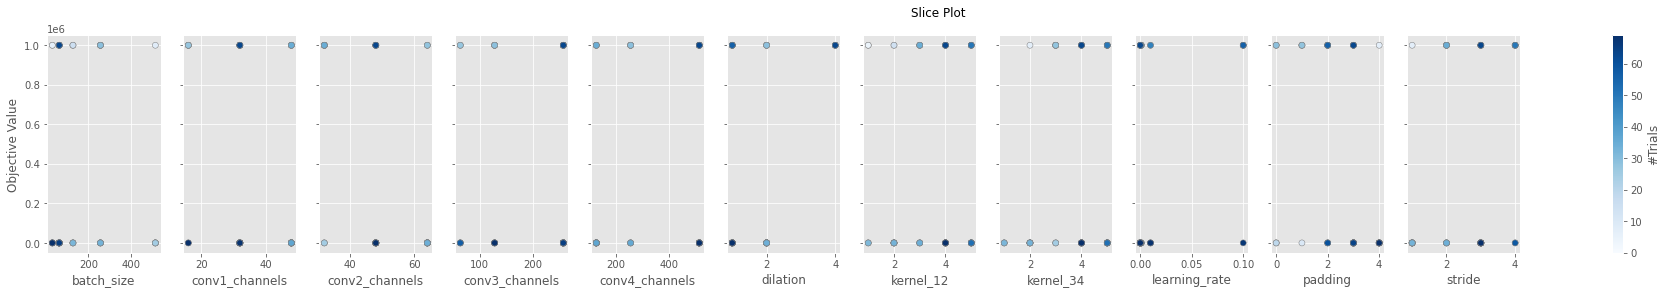

In [58]:
optuna.visualization.matplotlib.plot_slice(study, params=['learning_rate','learning_rate','batch_size','conv1_channels','conv2_channels','conv3_channels','conv4_channels',
 'kernel_12', 'kernel_34','padding', 'stride','dilation'])

C:\Users\Rania\AppData\Local\Temp/ipykernel_164/4239086276.py:3: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2022-10-05 16:43:00,032] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

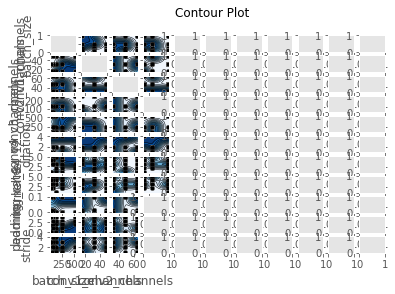

In [60]:
figure(figsize=(8, 6), dpi=80)

optuna.visualization.matplotlib.plot_contour(study, params=['learning_rate','learning_rate','batch_size','conv1_channels','conv2_channels','conv3_channels','conv4_channels',
 'kernel_12', 'kernel_34','padding', 'stride','dilation'])

In [61]:
MODEL_PATH= r'D:\Study 2 Results and Models\Study 2 Optimisation\CNN\2022_10_05 CNN Optimisation'

model_file = os.listdir(MODEL_PATH) 

# Changes the working directory to get the data from their location 
os.chdir(MODEL_PATH)
cwd = os.getcwd()

print(f'Current working directory is: {cwd}') 
print(f"There are {len(model_file)} files in the specified path.")

Current working directory is: D:\Study 2 Results and Models\Study 2 Optimisation\CNN\2022_10_05 CNN Optimisation
There are 38 files in the specified path.


In [62]:
for f in model_file:
    if f.endswith((".pt")):
        checkpoint = torch.load(f)
        best_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['val_loss']
        dtw_total = checkpoint['dtw_distance']

        print(f'{f}: best_epoch: {best_epoch}, best_val_loss: {best_val_loss:.5f}, dtw_distance: {dtw_total:.5f}')

CNN-trial0.pt: best_epoch: 40, best_val_loss: 0.02842, dtw_distance: 26.85105
CNN-trial1.pt: best_epoch: 1, best_val_loss: 0.00134, dtw_distance: 8.01342
CNN-trial10.pt: best_epoch: 38, best_val_loss: 0.00262, dtw_distance: 8.51679
CNN-trial13.pt: best_epoch: 40, best_val_loss: 0.02623, dtw_distance: 23.40541
CNN-trial14.pt: best_epoch: 32, best_val_loss: 0.00002, dtw_distance: 9.07954
CNN-trial15.pt: best_epoch: 35, best_val_loss: 0.00245, dtw_distance: 11.62260
CNN-trial16.pt: best_epoch: 40, best_val_loss: 0.00295, dtw_distance: 7.18908
CNN-trial17.pt: best_epoch: 2, best_val_loss: 0.00039, dtw_distance: 13.40658
CNN-trial18.pt: best_epoch: 5, best_val_loss: 0.00206, dtw_distance: 9.12923
CNN-trial19.pt: best_epoch: 1, best_val_loss: 0.00128, dtw_distance: 12.00246
CNN-trial2.pt: best_epoch: 8, best_val_loss: 0.00876, dtw_distance: 12.18917
CNN-trial20.pt: best_epoch: 2, best_val_loss: 0.00338, dtw_distance: 11.10058
CNN-trial21.pt: best_epoch: 34, best_val_loss: 0.00080, dtw_distan

In [ ]:
#load model 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint(path)

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(train_loss[:], lw=2, label='Train Loss')
ax.plot(val_loss[:], lw=2, label='Val Loss')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(train_loss[:], lw=2, label='Train Loss')
ax.plot(val_loss[:], lw=2, label='Val Loss')
ax.plot(lt_loss[:], lw=2, label='Long term prediction Loss')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(dtw_loss, lw=2, label='dtw')
plt.xlabel("Epoch")
plt.ylabel("Distance")
plt.legend()
plt.show()

In [ ]:
plt.plot(dtw_loss)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(np.log(train_loss[:]), lw=2, label='Train Loss')
ax.plot(np.log(val_loss[:]), lw=2, label='Val Loss')
ax.plot(np.log(lt_loss[:]), lw=2, label='Long term prediction Loss')

ax.set_xlabel("Epoch")
ax.set_ylabel("Log Loss (MSE)")
ax.legend()
plt.show()

In [ ]:
test_dataset = X_val_lt.to(DEVICE)
with torch.no_grad():
    test_predictions = model(test_dataset)

test_predictions.shape

In [ ]:
#Single Joint Plot
# x1 = np.arange(0,100)
# x2 = 101
# s = 200

# fig, ax = plt.subplots(1,1,figsize=(15,5))

# plt.plot(x1, test_dataset[s,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label = 'input')
# plt.scatter(x2, test_predictions[s,:,0].cpu().numpy(), lw=6, c='g', label='prediction')

# plt.xlabel('Time-steps')
# plt.ylabel('Angle (normalised)')
# ax.legend(loc='lower left')
# plt.show()

In [ ]:
x1 = np.arange(0,100)
x2 = 101
s = 200

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11

for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, test_dataset[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label = 'input')
    axs[n[f][0],n[f][1]].scatter(x2, test_predictions[s,:,f].cpu().numpy(), lw=6, c='g', label='prediction')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

axLine, axLabel = ax.get_legend_handles_labels()
fig.legend(axLine, axLabel,           
           loc = 'lower right')

In [ ]:
extrapolation = torch.zeros((1,200, len(features))).to(DEVICE)
seed_batch = test_dataset[s,:,:].unsqueeze(0).to(DEVICE)
current_batch = seed_batch
with torch.no_grad():
    for i in range(200):
        predicted_value = model(current_batch)
        extrapolation[:,i,:] = predicted_value
        current_batch = torch.cat((current_batch[:,1:,:], predicted_value), axis=1)

seed_batch.shape

In [ ]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(x1, seed_batch[:,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
plt.plot(x3, extrapolation[:,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
plt.plot(x3, Y_val_lt[s,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
plt.legend()

In [ ]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, seed_batch[:,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
    axs[n[f][0],n[f][1]].plot(x3, extrapolation[:,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
    axs[n[f][0],n[f][1]].plot(x3, Y_val_lt[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

axLine, axLabel = ax.get_legend_handles_labels()
fig.legend(axLine, axLabel,           
           loc = 'lower right')

### Calculating MSE and MAE

In [ ]:
print(f'shape of X validation data: {X_val.shape}, Y validation data: {Y_val.shape}')

In [ ]:
# Calculate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(X_val.to(DEVICE))

#Denormalise X_val and Y_val and predictions 
input_val = denormalise(X_val.cpu().numpy(), scalars)
actual_val = denormalise(Y_val.cpu().numpy(), scalars)
preds_val = denormalise(test_predictions.cpu().numpy(), scalars)

In [ ]:
# mse = np.mean((actual_val-preds_val) ** 2)
# mae = np.mean(np.abs(actual_val-preds_val))

val_mse_loss, val_mse_std = mse_loss(preds_val, actual_val, reduction='mean', format='np')
val_mae_loss, val_mae_std = mae_loss(preds_val, actual_val, reduction='mean', format='np')

print(f'Val MSE Loss: {val_mse_loss:.5}, Val MSE std: {val_mse_std:.5}')
print(f'Val MAE Loss: {val_mae_loss:.5}, Val MAE std: {val_mae_std:.5}')


In [ ]:
for f in range(len(features)):
    print(f' error for {features[f]} is: {np.mean(abs(preds_val[:,:,f]-actual_val[:,:,f])):.3f}')

In [ ]:
diff = abs(preds_val[:,:,0] -actual_val[:,:,0])
plt.hist(diff.squeeze(), 60)
plt.xlabel('Error between actual and predictions (degrees)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
x1 = np.arange(0,100)
x2 = 101

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.plot(x1, input_val[s,:,0].reshape(-1,1).squeeze(), lw=3, c='b', label='input')
plt.scatter(x2, actual_val[s,:,0], lw=4, c='r', label='actual')
plt.scatter(x2, preds_val[s,:,0], lw=4, c='g', label='prediction')

plt.xlabel('Time-step')
plt.ylabel('Angle (degrees)')

ax.legend(loc="lower left")
plt.show()

### Model shape

In [ ]:
model.eval()

In [ ]:
# fname = 'Exp020_220906_MLP_dtw'
# path = r'D:\Study 2 Results and Models\Study 2 Experiments\Exp020_220906_MLP_dtw' + '\\'  + fname + '.pth'

# checkpoint = {'model': model,
#           'state_dict': model.state_dict(),
#           'optimizer' : optimizer.state_dict()}

# torch.save(checkpoint, path)

In [ ]:
## benchmark against naive output (making prediction only last value)
naive_1_train_output = np.zeros(actual_val.shape)

    
for f in range(len(features)):
    for s in range(actual_val.shape[0]):
        naive_1_train_output[s,:,f] = np.ones((output_window)) * input_val[s,-1,f]

In [ ]:
naive_1_mse_loss, naive_1_mse_std = mse_loss(naive_1_train_output, actual_val, reduction='mean', format='np')
naive_1_mae_loss, naive_1_mae_std = mae_loss(naive_1_train_output, actual_val, reduction='mean', format='np')

print(f'naive_1 MSE Loss: {naive_1_mse_loss}')
print(f'naive_1 MSE std: {naive_1_mse_std} ')
print(f'naive_1 MAE Loss: {naive_1_mae_loss}')
print(f'naive_1 MAE std: {naive_1_mae_std}')